In [1]:
import matplotlib 
%matplotlib inline

from matplotlib import pyplot as plt
matplotlib.rcParams['figure.figsize'] = [15, 12]

Generate some random 2D data to be classified- overlapping 2D multivariate normal


In [2]:
import numpy as np

data1 = np.random.multivariate_normal(-np.ones(2), 0.5*np.eye(2), 10000)
data2 = np.random.multivariate_normal(np.ones(2), 0.5*np.eye(2), 10000)

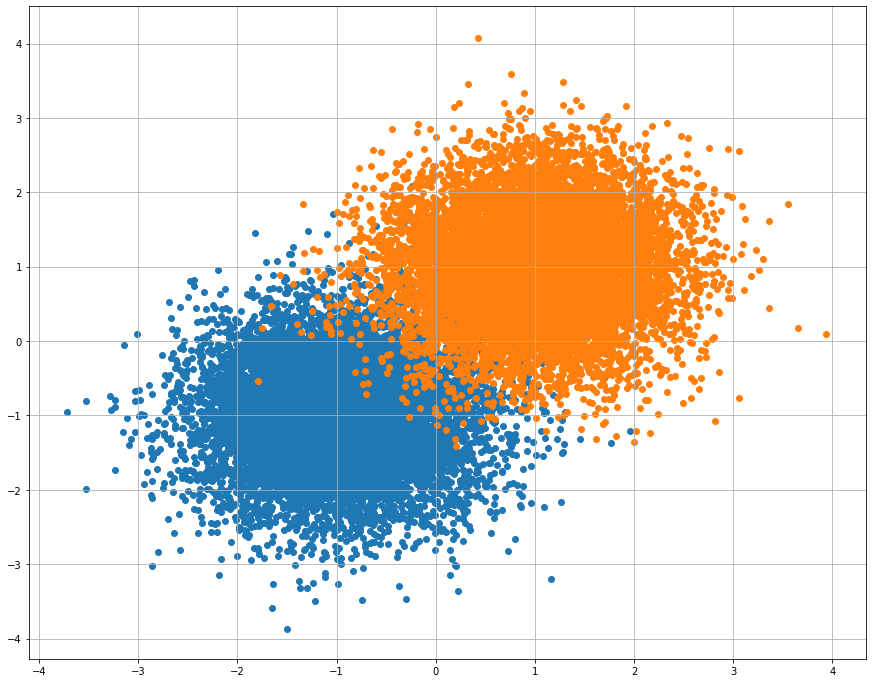

In [3]:
plt.scatter(data1[:, 0], data1[:, 1])
plt.scatter(data2[:, 0], data2[:, 1])
plt.grid()


Arbitrarily assign 1 or -1 to each category- note it does not matter which category is which

In [4]:
# data is in the columns: x, y, category
data = np.vstack([
    np.hstack([data1, -np.ones((10000, 1))]),
    np.hstack([data2, np.ones((10000, 1))])
])

In [5]:
# randomize so that when training data is presented in different order
indexes = np.random.permutation(data.shape[0])

In [6]:
data_rand = data[indexes]

data1_test = np.random.multivariate_normal(-np.ones(2), 0.5*np.eye(2), 1000)
data2_test = np.random.multivariate_normal(np.ones(2), 0.5*np.eye(2), 1000)

data_test = np.vstack([
    np.hstack([data1_test, -np.ones((1000, 1))]),
    np.hstack([data2_test, np.ones((1000, 1))])
])

Use the original perceptron algorithm that depends on the maximum norm of the data

In [7]:
norm = np.linalg.norm(data[:,:-1], axis=0).max()

In [8]:
def train_weights(data, eta, n_epoch, bias):

    weights = np.zeros(data.shape[1]-1)
    for epoch in range(n_epoch):
        sum_error = 0.0
        for row in data:
            xi = row[:2]
            yi = row[-1]
            activation = yi * (np.dot(weights, xi) + bias)
            if activation <= 0:
                bias += eta * yi * norm**2
                weights += eta*yi*xi
    return weights, bias

out = train_weights(data_rand, 0.01, 100, -1)

In [9]:
w, b = out

In [10]:
def test(weights, bias, data):
    correct = 0
    for row in data:
        xi = row[:2]
        yi = row[-1]
        test = np.dot(weights, xi) + bias
        if (test * yi) >= 0:
            correct += 1
    return correct

In [11]:
correct = test(w, b, data_rand)

In [12]:
print(correct)

19507


Now the algorithm in Jason Brownlee's page

In [13]:
def predict(row, weights, bias):
    activation = np.dot(row, weights) + bias
    return float(activation >= 0.0)

def train_weights2(data, eta, n_epoch, bias):
    weights = np.zeros(data.shape[1]-1)
    for epoch in range(n_epoch):
        for row in data:
            xi = row[:2]
            yi = row[-1]
            #if yi < 0:     # this function depends on data being classified as 0 or 1
            #    yi = 0
            activation = np.dot(weights, xi) + bias
            error = float(yi > 0) - (activation >= 0.0)
            bias += eta * error
            weights += eta * error * xi
    return weights, bias

out2 = train_weights2(data_rand, 0.01, 100, -1)
w2, b2 = out2
correct2 = test(w2, b2, data_rand)
print(correct2)

18509


Plot both over multiple trainings to compare

{1: 1958, 10: 1958, 50: 1958, 100: 1958, 200: 1958}


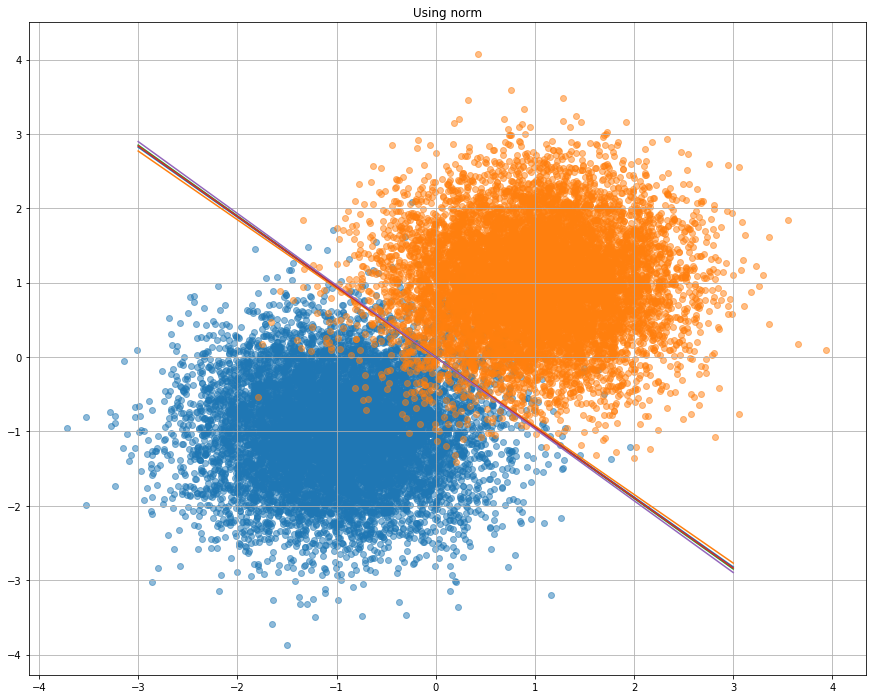

In [14]:


def show(wts, b):
    xes = np.linspace(-3, 3, num=1000)
    w0, w1 = wts
    yes = (-b -w0*xes)/w1
    return xes, yes
    
def plot_all(train_fn, title, eta=0.01):
    plt.scatter(data1[:, 0], data1[:, 1], alpha=0.5)
    plt.scatter(data2[:, 0], data2[:, 1], alpha=0.5)    
    coords = []
    results = {}

    for n in [1, 10, 50, 100, 200]:
        wts, b = train_fn(data_rand, eta, n, -0.05)
        coords.append(show(wts, b))
        results[n] = test(wts, b, data_test)

    for xes, yes in coords:
        plt.plot(xes, yes)

    plt.title(title)
    plt.grid()
    print(results)
    
plot_all(train_weights, 'Using norm', eta=1)



{1: 1923, 10: 1956, 50: 1871, 100: 1938, 200: 1763}


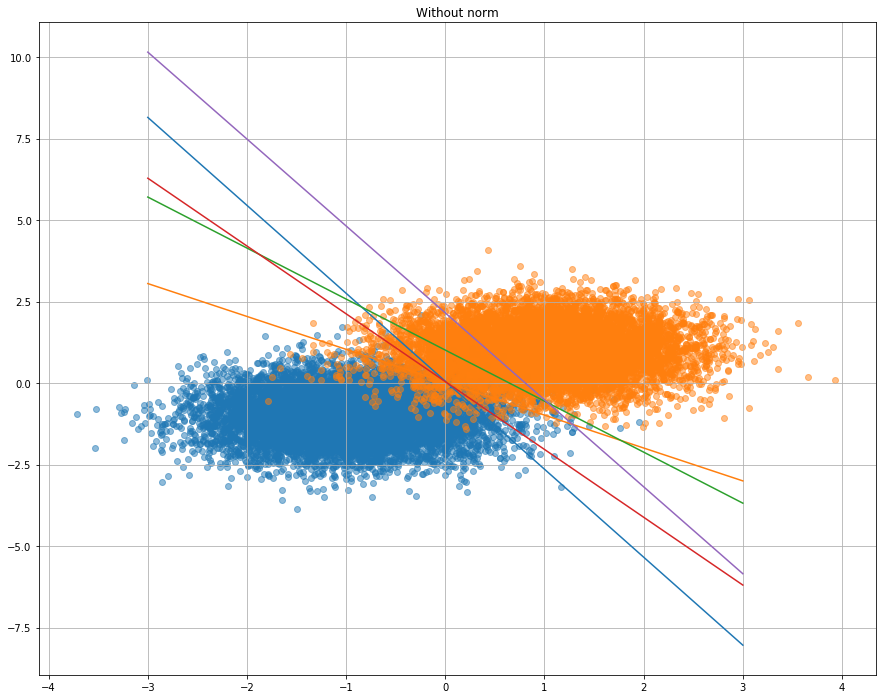

In [15]:
plot_all(train_weights2, "Without norm", eta=1)

## Why does it work?

Perceptron update rule is

$\mathbf{w}(t+1) = \mathbf{w}(t) + y(t) \mathbf{x}(t)$

$y(t)$ is the misclassified point - its sign is opposite to that of $\mathbf{w^T}(t) \mathbf{x}(t)$. 

Therefore $y(t) \mathbf{w^T}(t) \mathbf{x}(t) < 0$

$y(t) \mathbf{w^T}(t+1) \mathbf{x}(t) = y(t) [\mathbf{w^T}(t) + y(t) \mathbf{x^T}(t)] \mathbf{x}(t)$

$y(t) \mathbf{w^T}(t+1) \mathbf{x}(t) = y(t)\mathbf{w^T}(t)\mathbf{x}(t) + y^2(t) \mathbf{x^T}(t) \mathbf{x}(t)$

Because $y^2(t) \mathbf{x^T}(t) \mathbf{x}(t) > 0$

$\implies y(t) \mathbf{w^T}(t+1) \mathbf{x}(t) > y(t) \mathbf{w^T}(t) \mathbf{x}(t) $

Disregarding $y(t)$, this means that $\mathbf{w^T}(t+1) \mathbf{x}(t) > \mathbf{w^T}(t) \mathbf{x}(t) $

If $\mathbf{w}(t+1) \cdot \mathbf{x}(t) > \mathbf{w}(t) \cdot \mathbf{x}(t)$, geometrically, $\mathbf{w}(t+1)$ must be closer in angle to $\mathbf{x}(t)$ than $\mathbf{w}(t)$ was to $\mathbf{x}(t)$.

Therefore it must be moving in the right direction- closer to the boundary. If there is a boundary. 


## Exercise 1.4 from "Learning from data" (Abu-Mostafa)

Create some random target function $f$, data set $\mathcal{D}$. In 2 dimensions.

Choose a random line in the plane: $y = 2 - 3x$

Given weights $w_0, w_1, w_2$ and $\mathbf{x}$ $[1, x_1, x_2]$: if $h(\mathbf{x}) $ = sign$(\mathbf{w^Tx})$ 

then the dividing line is $w_0 + w_1x_1 + w_2x_2 = 0$

$w_2x_2 = -w_1x_1 - w_0$

$x_2 = -\frac{w_1}{w_2}x_1 - \frac{w_0}{w_2}$

$\implies \frac{w_1}{w_2} = 3,  \frac{w_0}{w_2} = -2$

/home/mog/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars


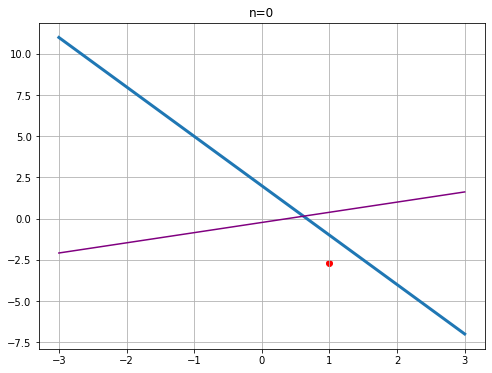

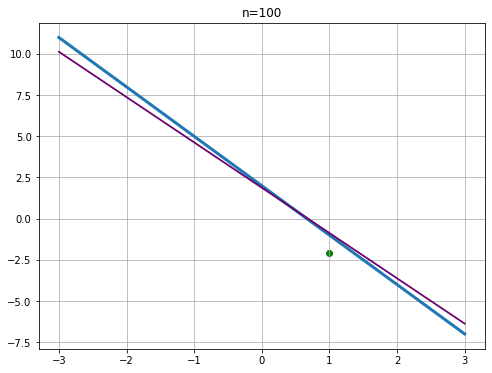

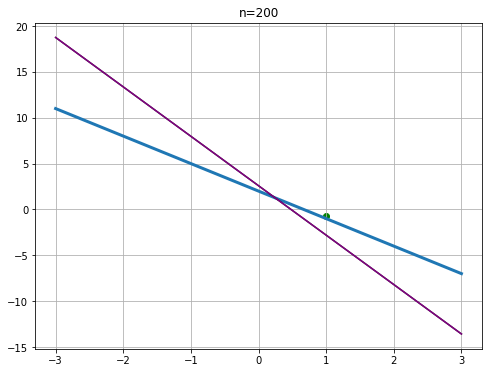

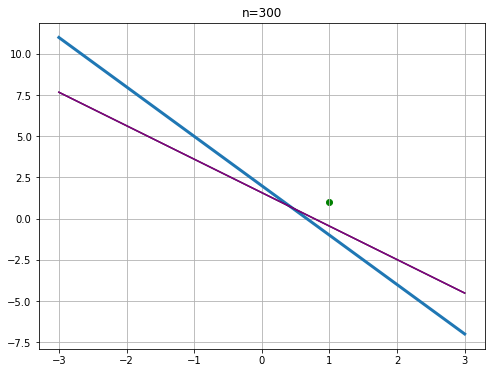

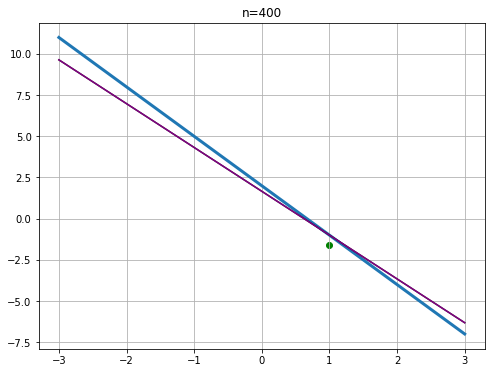

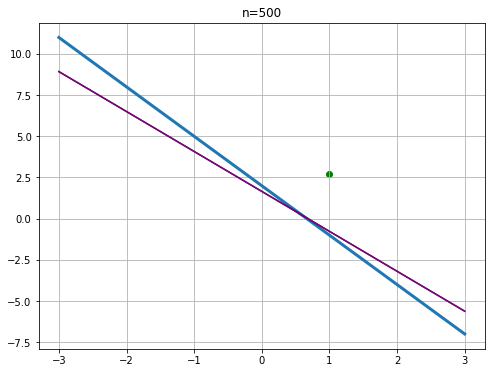

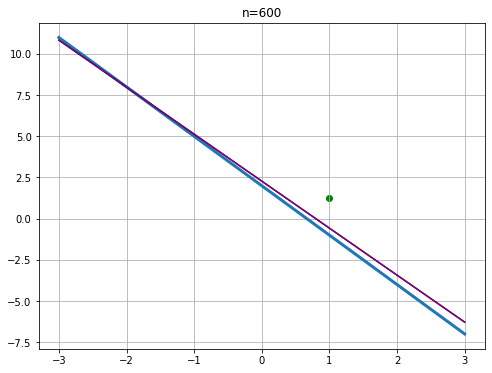

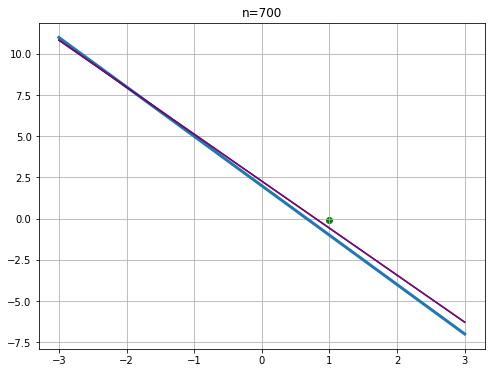

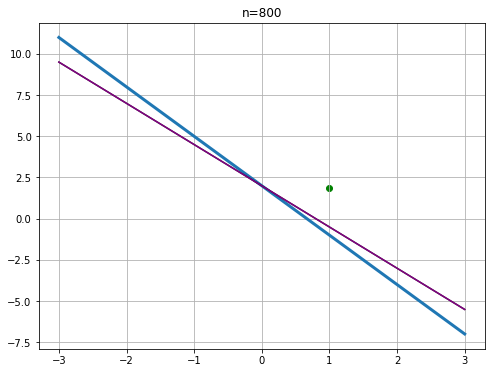

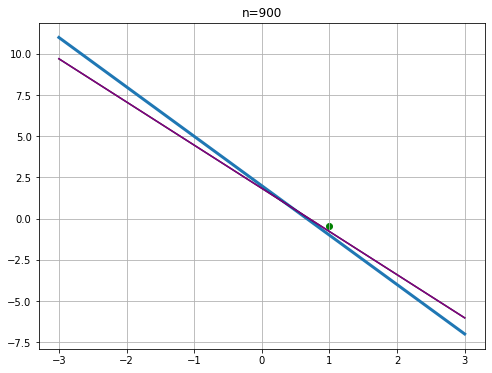

In [75]:
x = np.linspace(-3, 3, num=100)
y = 2-3*x


# generate N random points from x = -3 to 3 and y = 7.5 to -7.5

N = 1000
xes = 6 * (np.random.random(N) - 0.5)
yes = 15 * (np.random.random(N) - 0.5)

# For perceptron training, there is a w0 which is the bias.  
xdata = np.array([np.ones(N), xes, yes]).T

# above the line is +1, below the line is -1
yts = xdata[:, 2] > 2-3*xdata[:, 1]
# map False to -1 and True to 1
yts = np.where(yts, 1, -1)



def train(xt, yt, wt, title, plot=False):
    # w(t+1) = w(t) + y(t)w^T(t)x(t)
    test = np.dot(wt, xt)
    misclassified = np.sign(yt) != np.sign(test)
    #print(f"xt:{xt}, yt:{yt}, test:{test}, misclassified:{misclassified}")
    w0, w1, w2 = wt
    # y = -w1/w2 x - w0
    yold = (-w1/w2) *  x - w0/w2
    if misclassified:
        wt_plus_1 = wt + yt * xt
    else:
        wt_plus_1 = wt
    if plot: 
        w0, w1, w2 = wt_plus_1
        ynew = (-w1/w2) * x - w0/w2
        plt.figure(figsize=(8, 6))
        plt.plot(x, y, linewidth=3)
        plt.plot(x, yold, color='black', alpha=0.8)
        plt.plot(x, ynew, color='purple')
        # the training point
        if misclassified:
            plt.scatter([xt[0]], [xt[1]], color='red')
        else:
            plt.scatter([xt[0]], [xt[1]], color='green')
        plt.grid()
        plt.title(title)
    return wt_plus_1

wt = np.zeros(3)
for i, (xt, yt) in enumerate(zip(xdata, yts)):
    plot = i % 100 == 0
    wt_plus_1 = train(xt, yt, wt, f'n={i}', plot=plot)
    wt = wt_plus_1
    
# generate the line for the final weight vector
#ynew = (wt_plus_1[1] / wt_plus_1[0]) * x
    


In [76]:
wt_plus_1


array([-15.        ,  21.02087665,   7.0129832 ])

In [79]:
w0, w1, w2 = wt_plus_1

a = -w1/w2
b = -w0/w2

print(f"Equation is y = {a}x + {b}")

Equation is y = -2.997422928762167x + 2.1388900507066797


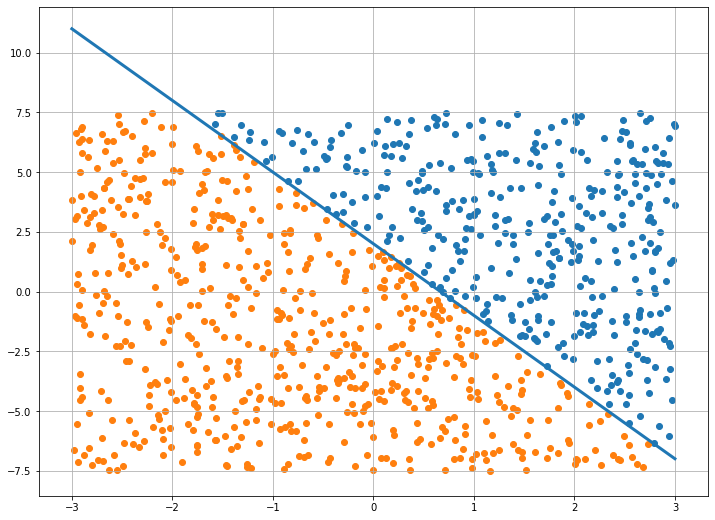

In [80]:
plt.figure(figsize=(12, 9))


plt.plot(x, y, linewidth=3)
for i, ynew in enumerate(ynews):
    if i == 0:
        continue
    plt.plot(x, ynew, label=i)
plt.scatter(xes[yts>0], yes[yts>0])
plt.scatter(xes[yts<0], yes[yts<0])
plt.grid()